In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [6]:
from flask import Flask, jsonify

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Precipitation Analysis

In [12]:
# Review Measurement data as a dictionary
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2cd55e66a20>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [13]:
# Review Station data as a dictionary
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2cd55ea3198>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [14]:
# Convert Measurement into Pandas DataFrame
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [15]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [16]:
# Using this date, retrieve the last 12 months of precipitation data by querying the 12 preceding months of data.
most_recent_date = dt.date(2017, 8 ,23)
last_12_months = most_recent_date - dt.timedelta(days=365)
last_12_months

datetime.date(2016, 8, 23)

In [22]:
# Perform a query to retrieve the data and precipitation scores (Select only the date and prcp values)
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(last_12_months, most_recent_date)).all()

# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by date. 
date_prcp_df = pd.DataFrame(date_prcp).set_index("date")
date_prcp_df = date_prcp_df.sort_values("date").dropna()

date_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


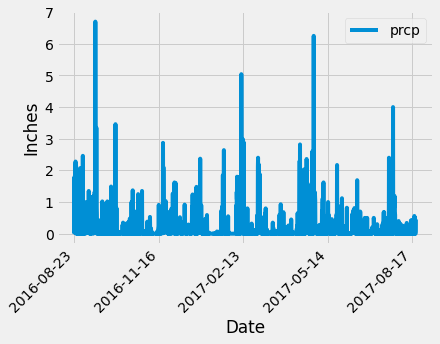

In [23]:
# Plot the results using the DataFrame plot method.
date_prcp_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.savefig("Images/Precipitation Analysis.png")
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [27]:
# Design a query to calculate the total number stations in the dataset
station_number = session.query(distinct(Measurement.station)).count()
print(f'There are total of {station_number} stations in the dateset.')

There are total of 9 stations in the dateset.


In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and observation counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Which station id has the highest number of observations?
print(f"The most active station is {active_stations[0][0]}.")

The most active station is USC00519281.


In [34]:
# Using the most active station id, calculate the lowest, highest, and average temperature.
lowest_tobs = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest_tobs = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg_tobs = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()

multiline_str = (
f"The Lowest Temperature: {lowest_tobs}\n"
f"The Highest Temperature: {highest_tobs}\n"
f"The Average Temperature: {avg_tobs: 2f}\n"
)
print(multiline_str, end="")

The Lowest Temperature: 54.0
The Highest Temperature: 85.0
The Average Temperature:  71.663781


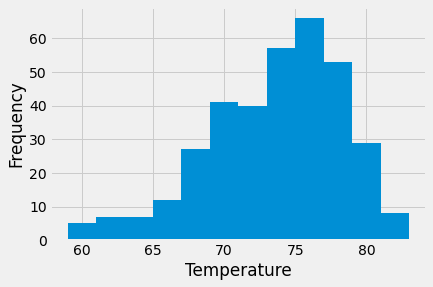

In [89]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins=12.
date_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(last_12_months, most_recent_date)).all()
date_tobs_df = pd.DataFrame(date_tobs).set_index("date")
plt.hist(date_tobs_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig("Images/Station Analysis.png")
plt.show()

# Close session

In [80]:
# Close Session
session.close()